In [1]:
import torch
import torchaudio as ta
import torchmetrics.classification as tc
from torch.utils.data import Dataset
import torchvision as tv
import torch.nn as nn
from torchaudio.transforms import Spectrogram
import torchvision.transforms as transforms
import torch.optim as optim
import torchaudio.functional as AF
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import os
from itertools import compress
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune import ExperimentAnalysis

ray.init(ignore_reinit_error=True)
print("Ray is initialized!")

CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA = 1
%load_ext tensorboard

f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-12-27 11:23:14,279	INFO worker.py:2007 -- Started a local Ray instance.


Ray is initialized!


f:\Persönliches\Git\BioOTon\.venv\Lib\site-packages\ray\_private\worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [2]:
# Method to move tensors to chosen device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class SpectroDataset(Dataset):
    def __init__(self, 
                recording_path: list[str], 
                label_path: list[str],
                #  transform: None | Callable,
                sampling_rate: int = 44100, #Hz
                loudness: int = 10,
                device = 'cpu',
                **kwargs):
        self.l_path = label_path
        self.r_path = recording_path

        dir_files = os.listdir(label_path)
        soundscape_file = os.path.join(self.l_path, list(compress(dir_files, [file.endswith("_single.parquet") for file in dir_files]))[0])
        sound_df = pd.read_parquet(soundscape_file)
        sound_df = sound_df.drop(sound_df.loc[sound_df.label.isna()].index)

        dir_files = os.listdir(recording_path)
        dir_files = list(compress(dir_files, [file.endswith(".flac") for file in dir_files]))

        dir_files = [int(f.split('_')[0]) for f in dir_files]

        recording_df = pd.DataFrame({"id":dir_files})

        self.file_df = sound_df.merge(recording_df)
        
        self.fileNames = self.file_df.id.values
        self.fileLabels = self.file_df.label.values
        # self.transforms = transform
        self.sampling_rate = sampling_rate
        self.loudness = loudness
        self.device = device
    
    def __len__(self):
        return len(self.fileNames)
    
    def __getitem__(self, idx):
        #x = torch.zeros(10*self.sr)
        print("Getting", os.path.join(self.r_path, (str(self.fileNames[idx])+"_audio.flac")))
        # Uses native sampling rate of the file
        # Normalize arg does bit depth normalization
        # Move to device specified
        wave, sr = ta.load(uri=os.path.join(self.r_path, (str(self.fileNames[idx])+"_audio.flac")))#, normalize=True)
        
        # Move to specified device, e.g. GPU
        wave = wave.to(torch.float32)
        
        # Resample to the sampling rate given by the args 
        if sr != self.sampling_rate:
            print(f"Initial sampling rate is {sr}, resampling to {self.sampling_rate}")
            wave = ta.functional.resample(wave, sr, self.sampling_rate)

        # LUFS normalization to a given loudness
        wave_loudness = AF.loudness(wave, self.sampling_rate)
        gain = self.loudness - wave_loudness
        multiplier = 10 ** (gain/20)
        wave = wave * multiplier
        
        # for testing sample only seconds 10 to 20
        llimit = int(self.sampling_rate * 5)#10)
 
        wave = wave[:, int(llimit):int(llimit*2)]

        # most of the time the first and last 10 seconds should be cut off 
        # wave = wave[:, int(llimit):int(llimit*5)+1]

        # Squeeze to go from 1,x to x shape tensor
        wave = to_device(wave.squeeze(), self.device)
        return wave, sr, int(self.fileLabels[idx])

def splitDataset(dataset, test_split_size = 0.2, val_split_size = 0.1):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    test_split = int(np.floor(test_split_size * dataset_size))
    val_split = int(np.floor(val_split_size * dataset_size))

    val_indices, test_indices, train_indices = indices[:val_split], indices[val_split: (val_split+test_split)], indices[(val_split+test_split):]

    return train_indices, test_indices, val_indices 

# https://medium.com/biased-algorithms/a-practical-guide-to-implementing-early-stopping-in-pytorch-for-model-training-99a7cbd46e9d
class EarlyStopping:
    def __init__(self, model, patience=5, delta=0.001, window = 5, path='checkpoints/checkpoint.pt', verbose=True):
        self.patience = patience
        self.delta = delta
        self.window = window
        self.values = []
        self.path = path
        self.verbose = verbose
        self.best_loss = None
        self.no_improvement_count = 0
        self.model = model
    
    def check_early_stop(self, val_loss):
        if (len(self.values) < self.window):
            self.values.append(val_loss)
            return False
        else:
            last_value = np.std(self.values)
            
            sliced_values = self.values[1:]
            sliced_values.append(val_loss)
            
            current_value = np.std(sliced_values)
            
            self.values = sliced_values
        if current_value<last_value:
            self.best_loss = val_loss
            self.no_improvement_count = 0
            # Save checkpoint if improvement observed
            torch.save(self.model.state_dict(), self.path)
            if self.verbose:
                print(f"Model improved; checkpoint saved at loss {val_loss:.4f}")
        else:
            self.no_improvement_count += 1
            if self.no_improvement_count >= self.patience:
                print("Early stopping triggered.")
                return True  # Signal to stop training
        return False
    
class AudioToLogSpectrogram(torch.nn.Module):
    def __init__(
        self,
        n_fft=4096,
        scale=1,
        power = 2,
        device="cpu"
    ):
        super().__init__()
        
        self.scale = scale
        self.spec = to_device(ta.transforms.Spectrogram(n_fft=n_fft, hop_length=n_fft//4, power=power), device)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample
        # waveform = ta.transforms.resample()

        # Convert to power spectrogram
        spec = self.spec(waveform)
        
        spec = torch.where(spec < 1, 1, spec)
        spectrogram = torch.log10(spec) / self.scale
        im = transforms.Resize((224, 224))(spectrogram[None, :, :]).squeeze()
        return im.unsqueeze(1)

class SpectroDataLoader():
    """
    """

    def __init__(self, datas, batch_size, samples, device='cpu'):
        self.waves = []
        self.lbs = []
        self.sr = []
        self.device = device

        # Append to each array the values returned in the dataset class (wave, sampling_rate, label)
        for idx in samples:
            print(idx)
            elem=datas[idx]
            self.waves.append(elem[0])
            self.sr.append(elem[1])
            self.lbs.append(elem[-1])

        # Shuffle all waves
        self.datas = list(zip(self.waves, self.lbs))
        random.shuffle(self.datas)

        # Attributes for batching
        self.batch_size = batch_size
        self.image_batches = []
        self.label_batches = []

        while (len(self.datas) / self.batch_size > 0) | (len(self.datas) % self.batch_size != 0):

            # first n entries of shuffled vector are batch
            batch = self.datas[:self.batch_size]

            wvs = []
            las = []

            # Need to separate images and labels into two tensors
            for wv, la in batch:
                wvs.append(wv)
                las.append(la)
            del self.datas[:self.batch_size]

            le = LabelEncoder()
            lef = le.fit(las)
            las = lef.transform(las)

            self.image_batches.append(wvs)
            self.label_batches.append(las)

    def __iter__(self):
        bat = list(zip(self.image_batches, self.label_batches))
        random.shuffle(bat)

        # return a random batch
        for image_batch, label_batch in bat:
            yield to_device([torch.stack(image_batch), torch.Tensor(label_batch)], self.device)

    def __len__(self):
        return len(self.image_batches)

def load_data(config):
    # Load  dataset
    ds = SpectroDataset("Z:\\Audio_data\\Dawn_chorus_conversion_flac", "F:\\Persönliches\\Git\\BioOTon", device = 'cuda')
    
    # Train / test / val split
    train_indices, test_indices, val_indices  = splitDataset(ds)

    # Get training and validation data
    train_dataloader = SpectroDataLoader(ds, config["batch_size"], samples= train_indices[:20], device = "cuda")
    val_dataloader = SpectroDataLoader(ds, config["batch_size"], samples= val_indices[:10], device = "cuda")

    return train_dataloader, val_dataloader

def load_model(config):
    
    # Initialize custom spectrogram module
    atls = AudioToLogSpectrogram(n_fft=config["nfft"], scale=config["scale"], power = config["power"], device = "cuda")

    # Adapt model structure to in and output
    res = tv.models.resnet18()
    adaptconv1 = nn.Conv2d (in_channels=1, kernel_size=res.conv1.kernel_size, stride=res.conv1.stride, padding = res.conv1.padding, bias=res.conv1.bias, out_channels=res.conv1.out_channels)
    res.conv1 = adaptconv1
    res.fc = nn.Linear(in_features=res.fc.in_features, out_features=37, bias=True)

    # Combine module and model and move it to the device
    nnw = nn.Sequential(atls, res)
    to_device(nnw, device)

    return nnw

def trialDir(trial):
    return f"/single_point/RayTune/{trial.trial_id[:6]}"

Using cuda device


In [3]:
def train_model(config):
    # Load data
    train_dataloader, val_dataloader = load_data(config)

    # Get the unique trial ID
    trial_id = tune.get_context().get_trial_id()


    nnw = load_model(config=config)

    writer = SummaryWriter("runs/single_points")

    networkPath = f"F:\\Persönliches\\Git\\BioOTon\\checkpoints\\checkpoint_{trial_id}.pt"
    loss = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=config["patience"], delta=config["EarlyDelta"], model = nnw, path = networkPath)

    # fused doesn't work without cuda
    if device == 'cuda':
        optimizer = optim.Adam(nnw.parameters(), lr=config["lr"], fused=True)
    else:
        optimizer = optim.Adam(nnw.parameters(), lr=config["lr"])

    # Train the network
    for epoch in range(config["epochs"]):  # loop over the dataset multiple times
        nnw.train()
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            outputs = nnw(inputs)

            labels_long = labels.type(torch.LongTensor)
            labels_long = to_device(labels_long.long(), device)
            # print(f"Batch Label Min: {labels_long.min()}, Max: {labels_long.max()}")

            los = loss(outputs, labels_long)


            l1_penalty = 0
            l2_penalty = 0

            # L1 and L 2Regularization
            for p in nnw.parameters():
                l1_penalty += p.abs().sum()
                l2_penalty += p.pow(2.0).sum()

            # Elastic Net Penalty
            elastic_penalty = config["l1"] * l1_penalty + config["l2"] * l2_penalty

            los += elastic_penalty

            # Clear the gradients
            optimizer.zero_grad()

            # Backpropagation to compute gradients
            los.backward()

            # Update model parameters
            optimizer.step()

            # print statistics
            running_loss += los.item()

        avg_loss = 0.0
        avg_vloss = 0.0
        total = 0
        correct = 0

        print(config["batch_size"], " : ", i % config["batch_size"])

        
        # Check against validation dataset
        running_vloss = 0.0

        # Switch to evaluation mode to omit some model specific operations like dropout
        nnw.train(False)
        for j, vdata in enumerate(val_dataloader, 0): 
            vinputs, vlabels = vdata
            vlabels_long = to_device(vlabels.type(torch.LongTensor), device)

            voutputs = nnw(vinputs)
            _, predicted = torch.max(voutputs.data, 1)
            total += vlabels_long.size(0)
            correct += (predicted == vlabels_long).sum().item()

            vloss = loss(voutputs, vlabels_long)
            running_vloss  +=vloss.item()
        
        nnw.train(True)
        avg_loss = running_loss / config["batch_size"]

        avg_vloss = running_vloss / len(val_dataloader)

        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch * len(train_dataloader) + i)

        print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.6f} vloss: {avg_vloss:.6f}')

        running_loss = 0.0

        tune.report({"loss": avg_vloss, "accuracy": correct/total})
            
            
        if early_stopping.check_early_stop(avg_vloss):
            print(f"Stopping training at epoch {epoch+1}")
            break

    nnw.eval()
    print('Finished Training')

    writer.flush()
    print("Flushed writer")

    torch.save(nnw.state_dict(), networkPath)

In [4]:
# https://medium.com/biased-algorithms/hyperparameter-tuning-with-ray-tune-pytorch-d5749acb314b
max_epochs = 25
# Define hyperparameter search space
config = {
    "lr": tune.loguniform(1e-5, 1e-2),          # Learning rate between 1e-5 and 1e-2
    "batch_size": tune.choice([8, 16, 32, 64, 128]), # qlograndint(32, 1024, q=2)
    "nfft" : tune.choice([512, 1024, 2048, 4096, 8192]),
    "scale" : tune.uniform(0.5, 4),
    "power" : tune.uniform(0.5, 4),
    "patience" : tune.choice([2, 3, 5, 7, 9]),
    "EarlyDelta" : tune.uniform(0.0015, 0.1),
    "epochs" : tune.randint(15, max_epochs),
    "l1" : tune.loguniform(0.0005, 0.004),
    "l2" : tune.loguniform(0.00075, 0.003)
    #"optimizer": tune.choice(["adam", "sgd"]),  # Optimizer choice: Adam or SGD
    # "layer_size": tune.randint(64, 256),        # Random integer for layer size (hidden units)
    # "dropout_rate": tune.uniform(0.1, 0.5)      # Dropout rate between 0.1 and 0.5
}

In [11]:
# Define HyperOpt-based search algorithm
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

trainable_with_resources = tune.with_resources(
    train_model, 
    resources={"cpu": 16, "gpu": 1, "accelerator_type:G":1}
)

optuna_search = OptunaSearch(
    metric=["loss", "accuracy"],
    mode=["min", "max"]
)

hyperopt_search = HyperOptSearch(
    metric="loss",
    mode="min",  # Minimize loss
    # points_to_evaluate # Use when some good hyperparameters are known as initial values
)

asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='accuracy',
    mode='max',
    max_t=max_epochs,
    grace_period=10,
    brackets=1,
)

# Pass the search algorithm to Ray Tune
tuner = tune.Tuner(
    trainable_with_resources,
    param_space=config,
    # tune_config=tune.TuneConfig(search_alg=hyperopt_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=2),
    tune_config=tune.TuneConfig(search_alg=optuna_search, num_samples=50, trial_dirname_creator=trialDir, max_concurrent_trials=4,),
    run_config=tune.RunConfig(storage_path='D:/ProgramFiles/RayResults', name="results")
)
tuner.fit()

(train_model pid=17324) 13119
(train_model pid=17324) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23853551_audio.flac
(train_model pid=17324) 13120
(train_model pid=17324) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23853553_audio.flac
(train_model pid=17324) 13121
(train_model pid=17324) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23862849_audio.flac
(train_model pid=17324) 13122
(train_model pid=17324) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\24104283_audio.flac
(train_model pid=17324) 13123
(train_model pid=17324) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\25408667_audio.flac
(train_model pid=17324) 13124
(train_model pid=17324) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26172099_audio.flac
(train_model pid=17324) 13125
(train_model pid=17324) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26563106_audio.flac
(train_model pid=17324) 13126
(train_model pid=17324) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\26747817_audio.flac
(train_m

2025-12-27 11:21:33,597	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-12-27 11:21:33,627	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'D:/ProgramFiles/RayResults/results' in 0.0293s.


(train_model pid=8728) 13119
(train_model pid=8728) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23853551_audio.flac
(train_model pid=8728) 13120
(train_model pid=8728) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23853553_audio.flac
(train_model pid=8728) 13121
(train_model pid=8728) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\23862849_audio.flac
(train_model pid=8728) 13122
(train_model pid=8728) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\24104283_audio.flac


2025-12-27 11:21:43,686	INFO tune.py:1041 -- Total run time: 222.21 seconds (211.91 seconds for the tuning loop).
2025-12-27 11:21:43,687	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="D:/ProgramFiles/RayResults/results", trainable=...)
2025-12-27 11:21:43,699	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_59fb499c: FileNotFoundError('Could not fetch metrics for train_model_59fb499c: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_59fb49')


(train_model pid=8728) 13123
(train_model pid=8728) Getting Z:\Audio_data\Dawn_chorus_conversion_flac\25408667_audio.flac


ResultGrid<[
  Result(
    metrics={'loss': 2.7959766387939453, 'accuracy': 0.1},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_65f1e5',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 2.962719440460205, 'accuracy': 0.2},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_b5c300',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 4.00521993637085, 'accuracy': 0.0},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_a4002d',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 3.2487456798553467, 'accuracy': 0.0},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_7b4b9b',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'loss': 3.4064942598342896, 'accuracy': 0.1},
    path='D:/ProgramFiles/RayResults/results/_single_point_RayTune_515bef',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metric

In [21]:
def getBestModel(path="D:\\ProgramFiles\\RayResults\\results", metric="loss", mode="min"):
    analysis = ExperimentAnalysis(path)

    # Get the best hyperparameters based on loss
    best_config = analysis.get_best_config(metric=metric, mode=mode)
    print("Best Hyperparameters:", best_config)

    # Get the best trial based on the metric
    best_result = analysis.get_best_trial(metric=metric, mode=mode)

    # df = analysis.results_df
    
    # Load model
    model = load_model(best_config)

    # Get list of checkpoints and find the file that matches the best result
    dir_files = os.listdir("./checkpoints")
    model_location = list(compress(dir_files, [file.endswith(str(best_result).split("_")[-1]+".pt") for file in dir_files]))[0]

    # load model state
    keys = model.load_state_dict(torch.load(f"checkpoints/{model_location}"))
    return model

In [22]:
model = getBestModel()

2025-12-27 11:31:02,445	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- train_model_59fb499c: FileNotFoundError('Could not fetch metrics for train_model_59fb499c: both result.json and progress.csv were not found at D:/ProgramFiles/RayResults/results/_single_point_RayTune_59fb49')


Best Hyperparameters: {'lr': 0.004350169597556156, 'batch_size': 16, 'nfft': 1024, 'scale': 2.330577977733603, 'power': 3.4310274173216007, 'patience': 9, 'EarlyDelta': 0.04299724660798981, 'epochs': 24, 'l1': 0.0021273244654414617, 'l2': 0.0014507701475758921}


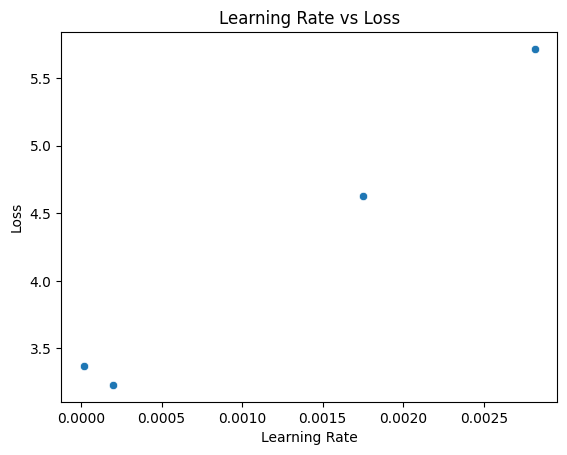

: 

: 

: 

: 

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot loss vs learning rate
sns.scatterplot(x="config/lr", y="loss", data=df)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
plt.show()

In [ ]:
%tensorboard --logdir runs/single_points/

Reusing TensorBoard on port 6008 (pid 22976), started 22:16:29 ago. (Use '!kill 22976' to kill it.)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
test_dataloader = SpectroDataLoader(ds, batch_size, samples= test_indices[:150], device = "cuda")

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

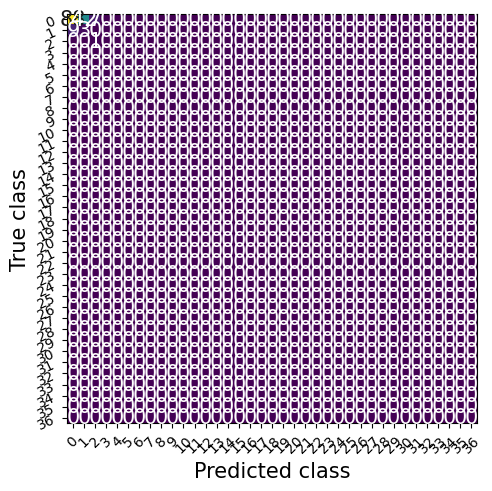

Recall of the custom cnn: tensor(0.6308, device='cuda:0')
F1-score of the custom cnn: tensor(0.3599, device='cuda:0')
Overall accuracy of the custom cnn: tensor(0.6308, device='cuda:0')


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
preds = torch.Tensor().to(device)
labs = torch.Tensor().to(device)

# Get predictions and corresponding real labels
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        inp = nnw(inputs)

        preds = torch.cat((preds, inp), 0).to(device)
        labs = torch.cat((labs, labels), 0)
        labs = labs.type(torch.LongTensor).to(device)


# Confusion Matrix
metric = tc.MulticlassConfusionMatrix(37).to(device)
metric.update(preds, labs)

fig_, ax_ = metric.plot()
plt.show()


# Compute recall
recall = tc.Recall(task="multiclass", average='macro', num_classes=37).to(device)
recall(preds, labs)
print("Recall of the custom cnn:", recall.compute())

# Compute F1-score
f1 = tc.MulticlassF1Score(37).to(device)
f1(preds, labs)
print("F1-score of the custom cnn:", f1.compute())


# Compute overall accuracy
oa = tc.MulticlassAccuracy(37).to(device)
oa(preds, labs)
print("Overall accuracy of the custom cnn:", oa.compute())